In [1]:
#%% Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample
import scipy.io as sio
from mne.decoding import CSP

from scipy.stats import ks_1samp
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon
from scipy import stats

import matplotlib.pyplot as plt 


In [2]:
#%% Leemos los datos y adaptamos la base de datos para obtener las epocas acondicionadas
#path_root = "/home/bzorzet/Academico/Neuro_Fairness/"
path_root = "/home/bzorzet/Academico/Neuro_Fairness/Shu_Dataset/"
dataset_field="DATASET_PREPROCESSING/"
dataset_path_root = path_root + dataset_field
save_figures = True
participants=["sub-001","sub-002","sub-003","sub-004","sub-005",
              "sub-006","sub-007","sub-008","sub-009","sub-010",
              "sub-011","sub-012","sub-013","sub-014","sub-015",
              "sub-016","sub-017","sub-018","sub-019","sub-020",
              "sub-021","sub-022","sub-023","sub-024","sub-025"]

sessions=["ses-01","ses-02","ses-03","ses-04","ses-05"]

In [3]:
dataset={}
for participant in participants:
    flag_participant=True
    dataset[participant]={}
    for session in sessions: 
        database_path= dataset_path_root + participant +"/"
        data_path=participant+"_"+session+"_task_motorimagery_eeg_preprocessing.mat"
        data=sio.loadmat(database_path + data_path)

        dataset[participant][session]= {}
        dataset[participant][session]['data'] = data['data']
        dataset[participant][session]['labels_trials'] = np.squeeze(data['labels_trials'])
        dataset[participant][session]['n_epochs'] = data['data'].shape[0]
        dataset[participant][session]['n_samples'] = data['data'].shape[2]
        dataset[participant][session]['n_chans'] = data['data'].shape[1]

        if flag_participant and session == sessions[-1]:
            dataset[participant]['group_medidator'] = data['group_medidator']
            dataset[participant]['gender'] = data['gender']
            dataset[participant]['id_participant'] = data['id_participant']
            dataset[participant]['sfreq'] = data['sfreq']
            ch_names = data['ch_names']
            it=0
            for ch in data['ch_names']:
                if ' ' in ch:
                    ch_names[it]=ch[:-1]
                it+=1
            dataset[participant]['ch_names']=ch_names 
            dataset[participant]['age'] = data['age']
            flag_participant = False

In [4]:
# Concatenamos las sesiones de los sujetos
nchan = dataset[participant][session]['n_chans']
nsamples = dataset[participant][session]['n_samples']

for participant in participants:
    data_=np.zeros((1,nchan,nsamples))
    labels_=np.zeros((1))
    for session in sessions: 
        data_ = np.concatenate((data_, dataset[participant][session]['data']),axis=0)
        labels_ = np.concatenate((labels_, dataset[participant][session]['labels_trials']),axis=0)
    data_ = data_[1:,:,:]
    labels_ = labels_[1:]
    
    dataset[participant]['data_sessions'] = data_.copy()
    dataset[participant]['labels_sessions'] = labels_.copy()
    dataset[participant]['data_gender'] =  np.array(list(dataset[participant]['gender']) * data_.shape[0])
    dataset[participant]['group_participant'] =  np.array(list([participant]) * data_.shape[0])

In [5]:
id_female = []
id_male = []
for participant in participants:
    if dataset[participant]['gender'] == 'M':
        id_male.append(participant)
    elif dataset[participant]['gender'] == 'F':
        id_female.append(participant)
print(f"Participantes hombres: {id_male}")
print(f"Participantes mujeres: {id_female}")

# Creamos un conjunto con los elementos de la lista1 para acelerar las búsquedas
conjunto1 = set(id_male)
conjunto2 = set(id_female)
# Recorremos la lista2 y comprobamos si cada elemento está en el conjunto1
index_male = []
index_female = []
for i, elemento in enumerate(participants):
    if elemento in conjunto1:
        index_male.append(i)
    else:
        index_female.append(i)
print(index_male)

Participantes hombres: ['sub-001', 'sub-002', 'sub-008', 'sub-012', 'sub-013', 'sub-015', 'sub-017', 'sub-018', 'sub-019', 'sub-021', 'sub-022', 'sub-023', 'sub-025']
Participantes mujeres: ['sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-009', 'sub-010', 'sub-011', 'sub-014', 'sub-016', 'sub-020', 'sub-024']
[0, 1, 7, 11, 12, 14, 16, 17, 18, 20, 21, 22, 24]


In [8]:
# Definimos la función que calcula la Divergencia de Kullback-Lleiber simetrizada
def Symmetrised_Divergence_KL(mu_p,mu_q,sigma_p,sigma_q):
    k=len(mu_p)
    
    inv_sigma_p=np.linalg.inv(sigma_p)
    inv_sigma_q=np.linalg.inv(sigma_q)
    
    term0_a=(mu_p - mu_q).T
    term0_b=inv_sigma_p + inv_sigma_q
    term0_c=mu_p - mu_q
    term1 = term0_a @ term0_b @ term0_c
    
    term2= np.trace( inv_sigma_q @ sigma_p )
    
    term3=np.trace( inv_sigma_p @ sigma_q )
    
    D_skl =(term1 + term2+ term3  - 2*k)/4
    
    return D_skl

In [11]:
n_features = 6
N_exp = 1
n_test_participant = 4

info_exp = {}
for it in range(N_exp):
    dic_aux = {}
    
    X_train = None
    labels_train = None
    
    idx_male = id_male.copy()
    idx_female = id_female.copy()
    
    # DIVIDE DATASET IN TRAIN, TEST AND VAL
    # TEST PARTICIPANTS:
    idx_male_test = sample(idx_male, n_test_participant)
    idx_female_test = sample(idx_female, n_test_participant)
    for it_ in range(n_test_participant):
        idx_male.remove(idx_male_test[it_])
        idx_female.remove(idx_female_test[it_])
    idx_test = idx_male_test + idx_female_test
    dic_aux['reg_idx_test'] = idx_test   
    
    idx_male_train = idx_male.copy()
    idx_female_train = idx_female.copy()
    idx_train = idx_male_train + idx_female_train
    dic_aux['reg_idx_train'] = idx_train


    # CONCATENAMOS EL CONJUNTO DE DATOS
    # TRAIN 
    X_train = np.zeros((1,nchan,nsamples))
    labels_train = np.zeros(1)
    for participant in idx_train:
        X_train = np.concatenate((X_train, dataset[participant]['data_sessions']),axis=0)
        labels_train = np.concatenate((labels_train, dataset[participant]['labels_sessions']),axis=0)
    X_train = X_train[1:,:]
    labels_train = labels_train[1:]
    
    #--------------------------  CSP TRANSFORM -------------------------------#
    csp = CSP(n_components = n_features, reg='oas', norm_trace = True)
    csp.fit(X_train, labels_train)

    #--------------------  Kullback Lleiber Divergence  ----------------------#
    data_csp = {}
    matrix_mean_csp = np.zeros((6,len(participants)))
    matrix_cov_csp = np.zeros((6,6,len(participants)))
    
    #Calculamos las medias y matrices de covarianza para cada sujeto luego de realizar la proyección de CSP
    it_ = 0
    for participant in participants:
        data_csp[participant] = csp.transform(dataset[participant]['data_sessions'])
        matrix_mean_csp[:,it_] = np.mean(data_csp[participant], axis=0)
        matrix_cov_csp[:,:,it_] = np.cov(data_csp[participant].T)
        it_ = it_+1

    means_male_csp = matrix_mean_csp[:,index_male].copy()
    mean_male = means_male_csp.mean(axis=1,keepdims=True)

    dist_males_mean = np.linalg.norm(means_male_csp - mean_male,axis = 0)
    idx_male_exclude = dist_males_mean.argmax()
    print(f'El sujeto que es excluido del análisis por tener una distancia con respecto a la media es {id_male[idx_male_exclude]}')
    
    dic_aux['reg_idx_male_exclude'] = idx_male_exclude


    D_KLS=np.zeros((len(participants),len(participants)))
    for it0 in range(0,len(participants)-1):
        for it1 in range(it0+1,len(participants)):
            mu_p = matrix_mean_csp[:,it0]
            mu_q = matrix_mean_csp[:,it1]
            sigma_p = matrix_cov_csp[:,:,it0]
            sigma_q = matrix_cov_csp[:,:,it1]
            D_KLS[it0,it1]=Symmetrised_Divergence_KL(mu_p,mu_q,sigma_p,sigma_q)

    info_exp[f'exp_{it+1}'] = {'General info':dic_aux, 'DKLS':D_KLS}

Computing rank from data with rank=None
    Using tolerance 31 (2.2e-16 eps * 32 dim * 4.4e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 31 (2.2e-16 eps * 32 dim * 4.4e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using OAS
Done.
El sujeto que es excluido del análisis por tener una distancia con respecto a la media es sub-002


                 statistics        p-value     H0  \
Female - Male      0.983980  6.426396e-119  False   
Female - Female    0.987213  2.224559e-125  False   
Male - Male        0.973808  8.290174e-124  False   

                                                     Description  
Female - Male    Reject H0, distribution is not normal(p < 0.05)  
Female - Female  Reject H0, distribution is not normal(p < 0.05)  
Male - Male      Reject H0, distribution is not normal(p < 0.05)  
                                 statics   p-value     H0  \
Female - Male / Male - Male       2623.0  0.845816   True   
Female - Male / Female - Female   1740.0  0.046467  False   

                                                                       Description  
Female - Male / Male - Male      Accept H0,  two distribution maybe have equal ...  
Female - Male / Female - Female  Reject H0, two distribution have not equal mea...  


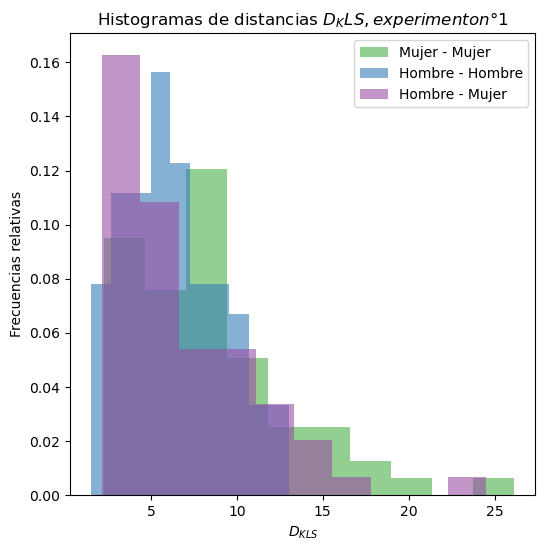

In [13]:
N_samples = int(12*11/2)
for it in range(N_exp):
    D_KLS = info_exp[f'exp_{it+1}']['DKLS']
    # Estimamos la divergencia de Kullback-Lleiber
    D_KLS_MF = []
    for idx_m in index_male:
        for idx_f in index_female:
            if D_KLS[idx_m,idx_f]!=0:
                D_KLS_MF.append(D_KLS[idx_m,idx_f])
                
    for idx_m in index_female:
        for idx_h in index_male:
            if D_KLS[idx_m,idx_h]!=0:
                D_KLS_MF.append(D_KLS[idx_m,idx_h])

    D_KLS_MF_ =  sample(D_KLS_MF, N_samples)
    D_KLS_MF_=np.array(D_KLS_MF_)
    
    D_KLS_MM = []

    for idx_m0 in index_male:
        for idx_m1 in index_male:
            if D_KLS[idx_m0,idx_m1]!=0:
                D_KLS_MM.append(D_KLS[idx_m0,idx_m1])
    D_KLS_MM=np.array(D_KLS_MM)

    D_KLS_FF = []
    for idx_f0 in index_female:
        for idx_f1 in index_female:
            if D_KLS[idx_f0,idx_f1]!=0:
                D_KLS_FF.append(D_KLS[idx_f0,idx_f1])
    D_KLS_FF=np.array(D_KLS_FF)

    info_exp[f'exp_{it+1}']['DKLS_MF']=D_KLS_MF
    info_exp[f'exp_{it+1}']['DKLS_MF_SELECTED']=D_KLS_MF_
    info_exp[f'exp_{it+1}']['DKLS_MM']=D_KLS_MM
    info_exp[f'exp_{it+1}']['DKLS_FF']=D_KLS_FF

    #%% Histogram 
    fig,ax=plt.subplots()
    fig.set_size_inches((6,6))
    cm = plt.cm.get_cmap('Set1')
    ax.hist(D_KLS_FF,label='Mujer - Mujer',density=True,alpha=0.6,color= cm(2))
    ax.hist(D_KLS_MM,label='Hombre - Hombre',density=True,alpha=0.6,color= cm(1))
    ax.hist(D_KLS_MF_,label='Hombre - Mujer',density=True,alpha=0.6,color= cm(3))

    ax.set_xlabel('$D_{KLS}$')
    ax.set_ylabel('Frecuencias relativas')
    ax.set(title=f'Histogramas de distancias $D_KLS, experimento n°{it+1}$')
    ax.legend()



    #%% Test Hypothesis
    alpha = 0.05
    # Norm Test
    test_norm = pd.DataFrame(columns=['statistics','p-value','H0','Description'])
    comparations = ['Female - Male','Female - Female','Male - Male']
    norm_test = ks_1samp(D_KLS_MF_,stats.norm.cdf)
    if norm_test.pvalue <= alpha:
        test_norm.loc['Female - Male']=[norm_test.statistic,norm_test.pvalue,False,f'Reject H0, distribution is not normal(p < {alpha})']
    else:
        test_norm.loc['Female - Male']=[norm_test.statistic,norm_test.pvalue,True,f'Accept H0, distribution is normal(p > {alpha})']
    norm_test = ks_1samp(D_KLS_FF,stats.norm.cdf)
    if norm_test.pvalue <= alpha:
        test_norm.loc['Female - Female']=[norm_test.statistic,norm_test.pvalue,False,f'Reject H0, distribution is not normal(p < {alpha})']
    else:
        test_norm.loc['Female - Female']=[norm_test.statistic,norm_test.pvalue,True,f'Accept H0, distribution is normal(p > {alpha})']
    norm_test = ks_1samp(D_KLS_MM,stats.norm.cdf)
    if norm_test.pvalue <= alpha:
        test_norm.loc['Male - Male']=[norm_test.statistic,norm_test.pvalue,False,f'Reject H0, distribution is not normal(p < {alpha})']
    else:
        test_norm.loc['Male - Male']=[norm_test.statistic,norm_test.pvalue,True,f'Accept H0, distribution is normal(p > {alpha})']


    print(test_norm)

    test = pd.DataFrame(columns=['statics','p-value','H0','Description'])
    U_test = stats.mannwhitneyu(D_KLS_MF_,D_KLS_MM)
    if U_test.pvalue <= alpha:
        test.loc['Female - Male / Male - Male']=[U_test.statistic,U_test.pvalue,False,f'Reject H0, two distribution have not equal mean(p < {alpha})']
    else: 
        test.loc['Female - Male / Male - Male']=[U_test.statistic,U_test.pvalue,True,f'Accept H0,  two distribution maybe have equal mean(p > {alpha})']

    U_test = stats.mannwhitneyu(D_KLS_MF_,D_KLS_FF)
    if U_test.pvalue <= alpha:
        test.loc['Female - Male / Female - Female']=[U_test.statistic,U_test.pvalue,False,f'Reject H0, two distribution have not equal mean(p < {alpha})']
    else: 
        test.loc['Female - Male / Female - Female']=[U_test.statistic,U_test.pvalue,True,f'Accept H0,  two distribution maybe have equal mean(p > {alpha})']

    print(test)




--------------------------------------------------------------------------------------------------------